In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals



%matplotlib inline
import sys
sys.path.insert(0,r"C:\Users\nanw0\GoogleDrive\SLAC\SLAC-Diling\8. 20 Winter\Beam_propagation\WPG\WPG-develop")

%load_ext autoreload

In [2]:
#Importing necessary modules:
import os
import sys
import copy

sys.path.insert(0,os.path.join('..','..'))
#sys.path.insert('../..')

import time
import numpy as np
import pylab as plt

# import auxiliar functions
%autoreload 2
from Auxiliary import *

In [3]:
''' directories '''
pulse_duration = 0.2e-15
# output data directory
strDataFolderName = 'WPG_output/' 
if not os.path.exists(strDataFolderName):
    mkdir_p(strDataFolderName)

# sub-folder for current sampling parameters
dirname_duration = strDataFolderName+'{}fs_beam/'.format(
    round(pulse_duration*1e15,1))
if not os.path.exists(dirname_duration):
    mkdir_p(dirname_duration)

# sub-sub-folder for incident beam
dirname_input = dirname_duration+'incident_beam/'
if not os.path.exists(dirname_input):
    mkdir_p(dirname_input)

# sub-sub-folder for propagated beam
dirname_split_delay = dirname_duration+'split-delay/'
if not os.path.exists(dirname_split_delay):
    mkdir_p(dirname_split_delay)
    
dirname_prop = dirname_duration+'prism/'
if not os.path.exists(dirname_prop):
    mkdir_p(dirname_prop)

In [4]:
fname_vcc1 = dirname_split_delay + '1_wavefront_after_vcc.h5'
fname_cc1 = dirname_split_delay + '1_wavefront_after_cc.h5'

mwf_vcc1 = Wavefront()
mwf_cc1 = Wavefront()
try:
    mwf_vcc1.load_hdf5(fname_vcc1)
    mwf_cc1.load_hdf5(fname_cc1)
except:
    print('cannot load wf')

In [40]:
''' prism parameters (PMMA) '''
n = 1 - 5.89e-6         # material refractive index
d_abs = 788e-6          # material absorption depth
#d_abs = 1e30             # turn off absorption
f_prism = 8.              # prism focal distance
overlap = 50e-6           # overlap of two beams after focal distance

bl_type = 'all'

'prism_trans_only'
'ang_only'
'shift_only'
'prism_and_ang'
'prism_and_shift'
'ang_and_shift'
'all'
bl_type

'all'

### Optics after split delay

R-space
R-space


Text(0, 0.5, 'thickness ($\\mu$m)')

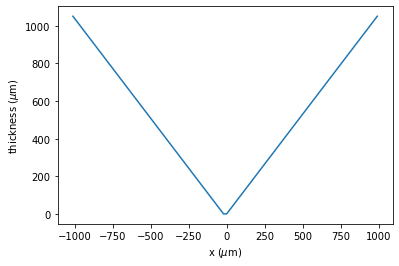

In [41]:
from Optics import *
''' half mask (VCC) '''
xmin, xmax, ymax, ymin = mwf_vcc1.get_limits()
npoints = mwf_vcc1.params.Mesh.nx
eStart = mwf_vcc1._srwl_wf.mesh.eStart
eFin = mwf_vcc1._srwl_wf.mesh.eFin
Mask = SRWLOptA('r','a',(xmax-xmin)/2, ymax-ymin, _x=(xmax-xmin)/4)

''' prism (CC) '''
xmin, xmax, ymax, ymin = mwf_cc1.get_limits()
prism_x = np.linspace(xmin, xmax, npoints)
prism_y = np.linspace(ymin, ymax, npoints)
Prism_Apt = SRWLOptA('r','a',(xmax-xmin)/2, ymax-ymin, _x=-(xmax-xmin)/4)
Prism_Tr = SRWLOptT(npoints, npoints, xmax-xmin, ymax-ymin,
                    _x=0,_y=0,_eStart=eStart,_eFin=eFin)
prism_x, prism_y = np.meshgrid(prism_x, prism_y)
prism_z = Single_Prism(prism_x, prism_y, n, f_prism, overlap, ori = 'x')
Calc_OPD_and_AmpTr(Prism_Tr, prism_z, n, d_abs)
Prism_Ang = SRWLOptAng(_ang_x = np.arctan(overlap/f_prism))
Prism_Shift = SRWLOptShift(_shift_x = overlap)

plt.figure()
plt.plot(prism_x[0]*1e6,prism_z[int(npoints/2)]*1e6)
plt.xlabel(r'x ($\mu$m)')
plt.ylabel(r'thickness ($\mu$m)')


### Beamline after split delay

In [42]:
drift_d = f_prism
DriftM = SRWLOptD(drift_d)   # drift after mask
DriftP = SRWLOptD(drift_d)         # drift after prism
#Wavefront Propagation Parameters:
#[0]:  Auto-Resize (1) or not (0) Before propagation
#[1]:  Auto-Resize (1) or not (0) After propagation
#[2]:  Relative Precision for propagation with Auto-Resizing (1. is nominal)
#[3]:  Allow (1) or not (0) for semi-analytical treatment of quadratic phase terms at propagation
#[4]:  Do any Resizing on Fourier side, using FFT, (1) or not (0)
#[5]:  Horizontal Range modification factor at Resizing (1. means no modification)
#[6]:  Horizontal Resolution modification factor at Resizing
#[7]:  Vertical Range modification factor at Resizing
#[8]:  Vertical Resolution modification factor at Resizing
#[9]:  Type of wavefront Shift before Resizing (not yet implemented)
#[10]: New Horizontal wavefront Center position after Shift (not yet implemented)
#[11]: New Vertical wavefront Center position after Shift (not yet implemented)
#               [ 0] [1] [2]  [3] [4] [5]  [6]  [7]  [8]  [9] [10] [11]
ppMask =        [ 0,  0, 1.0,  1,  0, 1.0, 1.0, 1.0, 1.0,  0,  0,   0]
ppDriftM =      [ 0,  0, 1.0,  1,  0, 1.0, 1.0, 1.0, 1.0,  0,  0,   0]
ppPrism_Apt =   [ 0,  0, 1.0,  1,  0, 1.0, 1.0, 1.0, 1.0,  0,  0,   0]
ppPrism_Tr =    [ 0,  0, 1.0,  0,  0, 1.0, 1.0, 1.0, 1.0,  0,  0,   0]
ppPrism_Ang =   [ 0,  0, 1.0,  0,  0, 1.0, 1.0, 1.0, 1.0,  0,  0,   0]
ppDriftP =      [ 0,  0, 1.0,  1,  0, 1.0, 1.0, 1.0, 1.0,  0,  0,   0]
ppPrism_Shift = [ 0,  0, 1.0,  1,  0, 1.0, 1.0, 1.0, 1.0,  0,  0,   0]

''' beamlines '''
# branch 1 (VCC)
name2 = '{}m_after_mask'.format(drift_d)
BL1 = SRWLOptC([Mask, DriftM], [ppMask, ppDriftM])

# branch 2 (CC)
name2_CC = '{}m_after_prism'.format(drift_d)

if bl_type == 'prism_trans_only':
    BL1_CC = SRWLOptC([Prism_Apt, Prism_Tr, DriftP],
                     [ppPrism_Apt, ppPrism_Tr, ppDriftP])

if bl_type == 'ang_only':
    BL1_CC = SRWLOptC([Prism_Ang, DriftP],
                     [ppPrism_Apt, ppDriftP])
    
if bl_type == 'shift_only':
    BL1_CC = SRWLOptC([DriftP, Prism_Shift],
                     [ppDriftP, ppPrism_Shift])
    
if bl_type == 'prism_and_ang':
    BL1_CC = SRWLOptC([Prism_Apt, Prism_Tr, Prism_Ang, DriftP],
                     [ppPrism_Apt, ppPrism_Tr, ppPrism_Ang, ppDriftP])
    
if bl_type == 'prism_and_shift':
    BL1_CC = SRWLOptC([Prism_Apt, Prism_Tr, DriftP, Prism_Shift],
                     [ppPrism_Apt, ppPrism_Tr, ppDriftP, ppPrism_Shift])
    
if bl_type == 'ang_and_shift':
    BL1_CC = SRWLOptC([Prism_Ang, DriftP, Prism_Shift],
                     [ppPrism_Ang, ppDriftP, ppPrism_Shift])

if bl_type == 'all':
    BL1_CC = SRWLOptC([Prism_Apt, Prism_Tr, Prism_Ang, DriftP, Prism_Shift],
                     [ppPrism_Apt, ppPrism_Tr, ppPrism_Ang, ppDriftP, ppPrism_Shift])
''' propagation '''
fname_vcc2 = dirname_prop + '2_wavefront_{}m_after_vcc_mask.h5'.format(drift_d)
mwf_vcc2 = propagate_wavefront(fname_vcc1, BL1, fname_vcc2)

fname_cc2 = dirname_prop + '2_wavefront_{}m_after_cc_prism.h5'.format(drift_d)
mwf_cc2 = propagate_wavefront(fname_cc1, BL1_CC, fname_cc2)


Optical Element: Aperture / Obstacle
Prop. parameters = [0, 0, 1.0, 1, 0, 1.0, 1.0, 1.0, 1.0, 0, 0, 0]
	Dx = 0.0010004388458129977
	Dy = 0.0007449831659342735
	ap_or_ob = a
	shape = r
	x = 0.0005002194229064989
	y = 0
	
Optical Element: Drift Space
Prop. parameters = [0, 0, 1.0, 1, 0, 1.0, 1.0, 1.0, 1.0, 0, 0, 0]
	L = 8.0
	treat = 0
	

*****reading wavefront from h5 file...
R-space
nx   100  range_x [-1.0e+00, 9.9e-01] mm
ny   100  range_y [-3.8e-01, 3.7e-01] mm
*****propagating wavefront (with resizing)...
save hdf5: WPG_output/0.2fs_beam/prism/2_wavefront_8.0m_after_vcc_mask.h5
done
Optical Element: Aperture / Obstacle
Prop. parameters = [0, 0, 1.0, 1, 0, 1.0, 1.0, 1.0, 1.0, 0, 0, 0]
	Dx = 0.0010004306056421285
	Dy = 0.002000874241237768
	ap_or_ob = a
	shape = r
	x = -0.0005002153028210643
	y = 0
	
Optical Element: Transmission (generic)
Prop. parameters = [0, 0, 1.0, 0, 0, 1.0, 1.0, 1.0, 1.0, 0, 0, 0]
	Fx = 1e+23
	Fy = 1e+23
	arTr = array of size 20000
	extTr = 0
	mesh = Radiation M

R-space
R-space
R-space
R-space


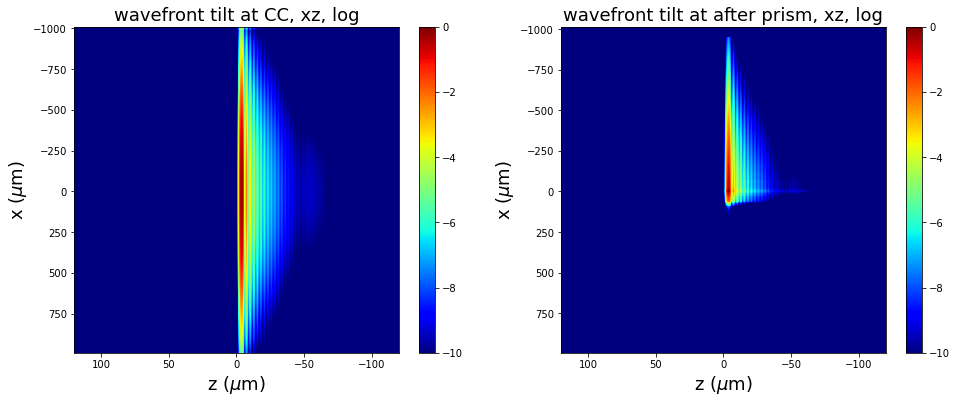

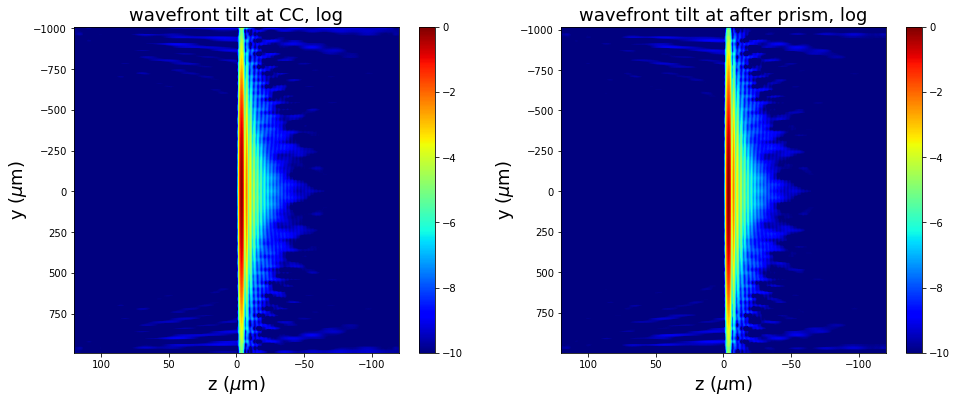

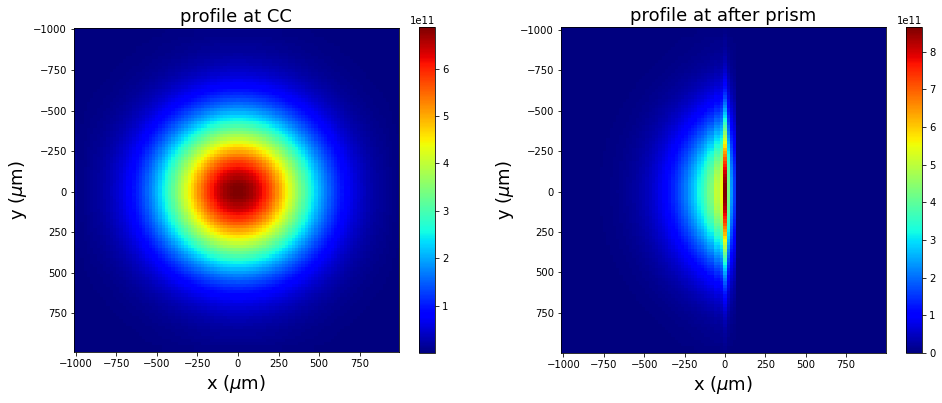

In [43]:
# Plot x-z profile
fig = plt.figure(figsize=(16,6))
ax1 = fig.add_subplot(121)
plot_tilt_from_wf(mwf_cc1, label='CC, xz', ori='H', if_log=1)
#ax1.set_aspect('equal')
ax2 = fig.add_subplot(122)
plot_tilt_from_wf(mwf_cc2, label='after prism, xz', ori='H', if_log=1)
#ax2.set_aspect('equal')
plt.savefig(dirname_prop+'xz_{}_{}m_after_prism.png'.format(bl_type, drift_d))

# Plot y-z (tilt) profile
fig = plt.figure(figsize=(16,6))
ax1 = fig.add_subplot(121)
plot_tilt_from_wf(mwf_cc1, label='CC', ori='V', if_log=1)
#ax1.set_aspect('equal')
ax2 = fig.add_subplot(122)
plot_tilt_from_wf(mwf_cc2, label='after prism', ori='V', if_log=1)
#ax2.set_aspect('equal')
plt.savefig(dirname_prop+'yz_{}_{}m_after_prism.png'.format(bl_type, drift_d))

# Plot x-y (spatial) profile
fig = plt.figure(figsize=(16,6))
ax1 = fig.add_subplot(121)
plot_spatial_from_wf(mwf_cc1, label='CC', if_log=0)
ax1.set_aspect('equal')
ax2 = fig.add_subplot(122)
plot_spatial_from_wf(mwf_cc2, label='after prism', if_log=0)
ax2.set_aspect('equal')
plt.savefig(dirname_prop+'xy_{}_{}m_after_prism.png'.format(bl_type, drift_d))


### Compress save

In [48]:
fname_vcc2 = dirname_prop+'wf_{}_compressed.h5'.format(name2)
fname_cc2 = dirname_prop+'wf_{}_compressed.h5'.format(name2_CC)

''' after prism '''
for filename in os.listdir(dirname_prop):
    if filename.endswith('.h5'):
        if not filename.endswith('compressed.h5'):
            os.remove(dirname_prop+filename)

compress_save(mwf_vcc2, fname_vcc2)
compress_save(mwf_cc2, fname_cc2)


R-space
R-space


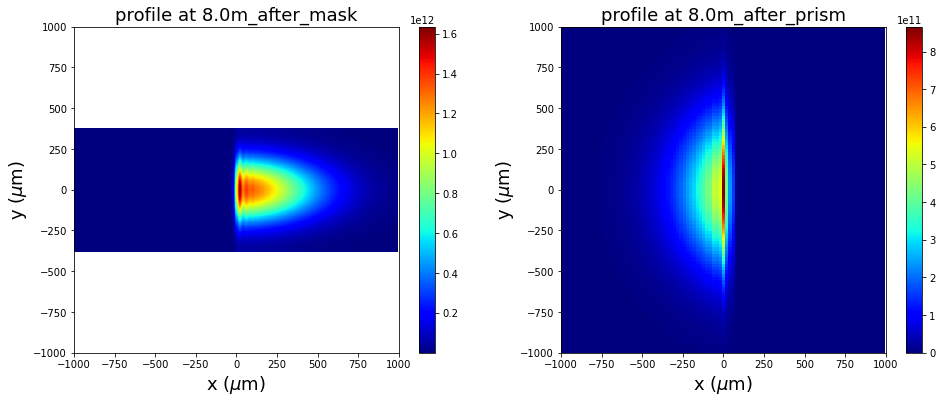

In [49]:
# spatial profiles
if_log = 0
fov_x = 1000
fov_y = 1000
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plot_spatial_from_file(fname_vcc2, label=name2, if_log=if_log)
plt.xlim([-fov_x,fov_x]); plt.ylim([-fov_y,fov_y])

plt.subplot(1,2,2)
plot_spatial_from_file(fname_cc2, label=name2_CC, if_log=if_log)
plt.xlim([-fov_x,fov_x]); plt.ylim([-fov_y,fov_y])

plt.savefig(dirname_prop+'profile_{}m_after_prism.png'.format(drift_d),transparent=True)

In [50]:
tstart = time.time()
''' interpolation and addition '''
# calculate cc branch's value on vcc branch's axis
E_real_0, E_img_0 = interp_wf(mwf_cc2, mwf_vcc2)
print(time.time()-tstart)

# get vcc branch's field
x1, y1, E_real_1, E_img_1 = get_field(mwf_vcc2)


23.379401206970215


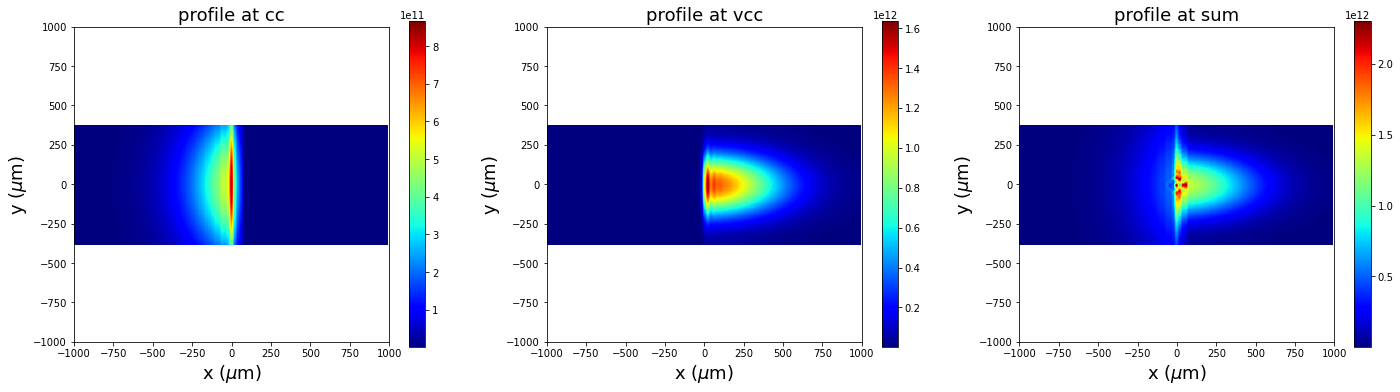

In [51]:
# plots
fov_x = 2000   # um
fov_y = 2000   # um

fig = plt.figure(figsize=(24,6))
ax1 = fig.add_subplot(131)
plot_spatial(x1, y1, E_real_0, E_img_0, label='cc', if_log=0)
plt.xlim([-fov_x/2,fov_x/2]); plt.ylim([-fov_y/2,fov_y/2])
ax1.set_aspect('equal')

ax2 = fig.add_subplot(132)
plot_spatial(x1, y1, E_real_1, E_img_1, label='vcc', if_log=0)
plt.xlim([-fov_x/2,fov_x/2]); plt.ylim([-fov_y/2,fov_y/2])
ax2.set_aspect('equal')

ax3 = fig.add_subplot(133)
plot_spatial(x1, y1, E_real_0+E_real_1, E_img_0+E_img_1, label='sum', if_log=0)
plt.xlim([-fov_x/2,fov_x/2]); plt.ylim([-fov_y/2,fov_y/2])
ax3.set_aspect('equal')